In [12]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import math
import string
import gc
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from nltk.tokenize import word_tokenize
from datetime import datetime
from textblob import TextBlob
from text_processing import clean

In [3]:
posts_pkl_path = os.path.join('..', '..', "combined_bigquery_processed.pkl")
posts_df = pd.read_pickle(posts_pkl_path)

In [3]:
# this will take 1-2 minutes
# posts_file_path = os.path.join('..', 'data', 'raw', "combined_bigquery_processed.csv")
# posts_df = pd.read_csv(posts_file_path)

In [4]:
# should have 10,015,586 rows
print(f"number of rows in data: {len(posts_df)}")

number of rows in data: 10015586


In [5]:
pd.set_option('display.max_columns', None)
posts_df.head()

,selftext,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_date,post_type
0,"Another one of their smug, preachy ass headlin...",NaN,NaN,NaN,ThisIsTedSpeaking,GA,NaN,1548979405,t5_38unr,t3_alr7qq,t3_alr7qq,3,1552341042,0,0,efhd3oz,The_Donald,NaN,NaN,georgia-us-state,2019-01-31,extant
1,enema has been pretending to be a rapper for y...,NaN,NaN,NaN,mastermeatlock,VA,NaN,1549238712,t5_38unr,t3_amv0ki,t3_amv0ki,9,1553492656,0,0,efownuo,The_Donald,NaN,NaN,virginia,2019-02-03,extant
2,That area from Abilene to border (I-20 to I-10...,NaN,NaN,NaN,txladyvoter,#45,NaN,1549238721,t5_38unr,t3_amr6kj,t1_efo6zai,3,1553492661,0,0,efowo8r,The_Donald,NaN,NaN,MURICA,2019-02-03,extant
3,She's got the politician fist point down,NaN,NaN,NaN,Tdaccount841,SC,NaN,1549152215,t5_38unr,t3_amjtig,t3_amjtig,1,1553452149,0,0,efmhy5u,The_Donald,NaN,NaN,south-carolina,2019-02-02,extant
4,Imagine getting paid to drop three words on a ...,NaN,NaN,NaN,Ask_If_Im_A_Cactus,Кактус,NaN,1549756908,t5_38unr,t3_aoy05c,t3_aoy05c,4,1553983794,0,0,eg4fg9x,The_Donald,NaN,NaN,ivanka,2019-02-09,extant


In [6]:
posts_df.describe()

,score_hidden,name,downs,created_utc,score,retrieved_on,controversiality,gilded,ups
count,0.0,0.0,0.0,1.001559e+07,1.001559e+07,1.001559e+07,1.001559e+07,1.001559e+07,0.0
mean,NaN,NaN,NaN,1.561263e+09,8.982444e+00,1.567742e+09,8.746368e-03,6.030601e-05,NaN
std,NaN,NaN,NaN,9.027785e+06,3.201599e+01,1.113914e+07,9.311214e-02,8.383723e-03,NaN
min,NaN,NaN,NaN,1.546301e+09,-8.200000e+02,1.550713e+09,0.000000e+00,0.000000e+00,NaN
25%,NaN,NaN,NaN,1.553330e+09,1.000000e+00,1.556517e+09,0.000000e+00,0.000000e+00,NaN
50%,NaN,NaN,NaN,1.561057e+09,3.000000e+00,1.570363e+09,0.000000e+00,0.000000e+00,NaN
75%,NaN,NaN,NaN,1.569009e+09,7.000000e+00,1.577285e+09,0.000000e+00,0.000000e+00,NaN
max,NaN,NaN,NaN,1.577837e+09,5.340000e+03,1.586450e+09,1.000000e+00,8.000000e+00,NaN


In [4]:
posts_df.groupby('post_type')['post_type'].count() #majority are either removed or blank... need to investigate this for sure

post_type
blank          897
deleted     536690
extant     8983413
removed     494586
Name: post_type, dtype: int64

In [8]:
def create_count_data(df, group):
    """
    create dataframe of counts based on groupby
    :param df: pandas dataframe
    :param group: name of column to groupby
    :return: dataframe of counts for each group
    """
    counts = df.groupby(group).size().to_frame('count')
    counts.reset_index(inplace=True)
    return counts

def create_barplot(count_data, grouped_by_col, count_col, title):
    """
    create bar plot based on grouped_by_col
    """
    plt.figure(figsize=(20,6))
    p = sns.barplot(x=grouped_by_col, y=count_col,
                data=count_data)
    p.set_xticklabels(p.get_xticklabels(), rotation=40, ha="right")
    plt.ylabel("Count", size=15)
    plt.xlabel(grouped_by_col, size=15)
    plt.title(title, size=18)
    plt.show()

In [6]:
posts_by_date = posts_df.groupby('created_date')['post_type'].value_counts().unstack()
posts_by_date.fillna(0, inplace=True)
posts_by_date.head()

post_type,blank,deleted,extant,removed
created_date,,,,
2018-12-31,0.0,322.0,5272.0,191.0
2019-01-01,0.0,1040.0,18630.0,888.0
2019-01-02,0.0,1223.0,20986.0,946.0
2019-01-03,1.0,1356.0,24190.0,1050.0
2019-01-04,1.0,1695.0,28213.0,1343.0


  post_type    count
0     blank      897
1   deleted   536690
2    extant  8983413
3   removed   494586


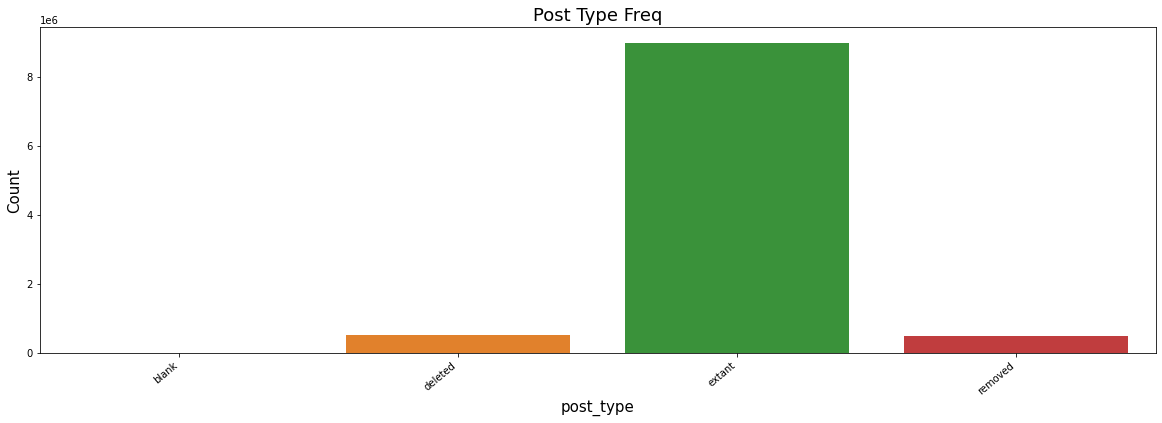

In [11]:
posts_count= create_count_data(posts_df, 'post_type')
print(posts_count)
create_barplot(posts_count, 'post_type', 'count', 'Post Type Freq')

Text(0.5, 1.0, 'Post type by date')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


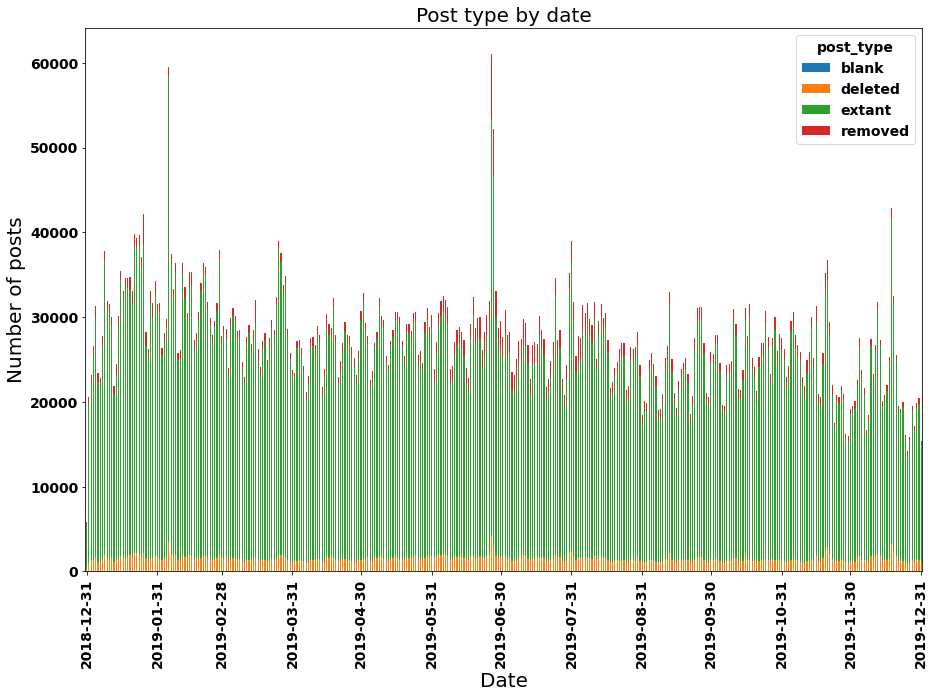

In [18]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (15,10)

ax = posts_by_date.plot(kind='bar', stacked=True)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_major_locator(fmt_month)
plt.ylabel("Number of posts", size=20)
plt.xlabel("Date", size=20)
plt.title("Post type by date", size=20)

# Create data set for analysis

In [10]:
print(posts_df.created_date.min())
print(posts_df.created_date.max())

2018-12-31
2019-12-31


In [11]:
# sample
# posts_df = posts_df.sample(frac=0.001, replace=False)

# by date
# posts_df = posts_df[(posts_df["created_date"] > '2019-05-31') & (posts_df["created_date"] < '2019-08-01')]

print(f"num rows in sample {len(posts_df)}")
print(posts_df.created_date.min())
print(posts_df.created_date.max())

num rows in sample 10015586
2018-12-31
2019-12-31


In [19]:
extant_posts = posts_df[posts_df['post_type'] == 'extant']
print(f"nrow in extant posts: {len(extant_posts)}")
# 8,983,413
extant_posts.head()

nrow in extant posts: 8983413


,selftext,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,...,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_date,post_type
0,"Another one of their smug, preachy ass headlin...",NaN,NaN,NaN,ThisIsTedSpeaking,GA,NaN,1548979405,t5_38unr,t3_alr7qq,...,1552341042,0,0,efhd3oz,The_Donald,NaN,NaN,georgia-us-state,2019-01-31,extant
1,enema has been pretending to be a rapper for y...,NaN,NaN,NaN,mastermeatlock,VA,NaN,1549238712,t5_38unr,t3_amv0ki,...,1553492656,0,0,efownuo,The_Donald,NaN,NaN,virginia,2019-02-03,extant
2,That area from Abilene to border (I-20 to I-10...,NaN,NaN,NaN,txladyvoter,#45,NaN,1549238721,t5_38unr,t3_amr6kj,...,1553492661,0,0,efowo8r,The_Donald,NaN,NaN,MURICA,2019-02-03,extant
3,She's got the politician fist point down,NaN,NaN,NaN,Tdaccount841,SC,NaN,1549152215,t5_38unr,t3_amjtig,...,1553452149,0,0,efmhy5u,The_Donald,NaN,NaN,south-carolina,2019-02-02,extant
4,Imagine getting paid to drop three words on a ...,NaN,NaN,NaN,Ask_If_Im_A_Cactus,Кактус,NaN,1549756908,t5_38unr,t3_aoy05c,...,1553983794,0,0,eg4fg9x,The_Donald,NaN,NaN,ivanka,2019-02-09,extant


In [20]:
# remove unnecesary large data obj, since we have extant_posts
del posts_df
gc.collect()

90

In [64]:
print(extant_posts.shape)
print(f"number of unique users: {extant_posts['author'].nunique()}")
author_count= create_count_data(extant_posts, 'author')
print(len(author_count[author_count['count']>1000]))
author_count.sort_values('count', ascending = False).head(50)

(8983413, 22)
number of unique users: 156231
1584


,author,count
7419,AutoModerator,322074
89532,[deleted],198437
24398,ENVYNITAZ,24309
21651,DiamondsOnTheFloor,16247
57391,OhLollyLollyPop,14190
67360,SAW2TH-55th,14019
113130,happycookie6,13236
82300,TrumpBrickBot,12135
53958,MythArcana,11898
123524,littleirishmaid,11841


In [62]:
print(author_count['count'][author_count.author=="AutoModerator"])
print(author_count['count'][author_count.author=="BotForceOne"])
author_count[(author_count.author!="AutoModerator") & (author_count.author!="[deleted]")].describe()

7419    322074
Name: count, dtype: int64
11976    2596
Name: count, dtype: int64


,count
count,156229.000000
mean,54.169853
std,298.196449
min,1.000000
25%,1.000000
50%,3.000000
75%,15.000000
max,24309.000000


Text(0.5, 1.0, 'Post type by date')

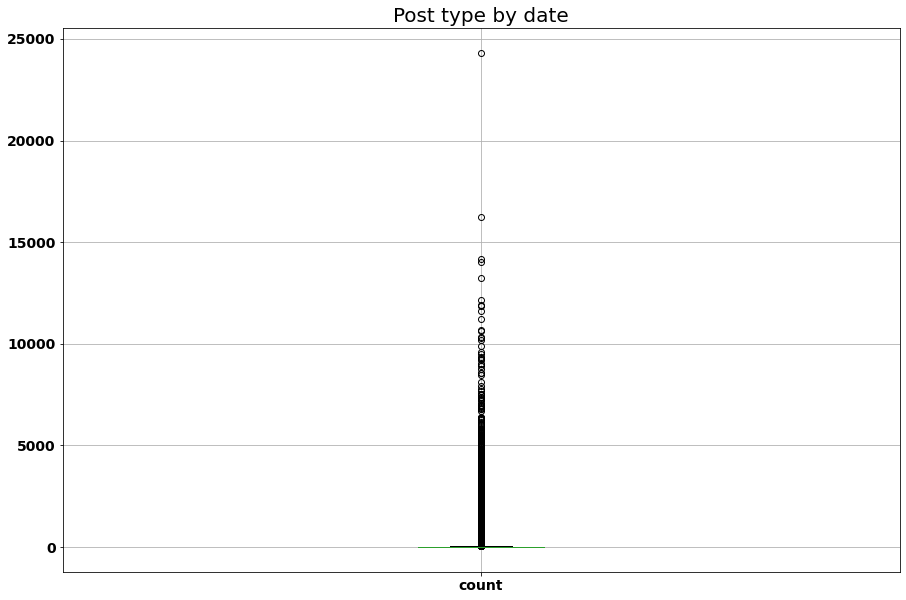

In [61]:
boxplot = author_count[(author_count.author!="AutoModerator") & (author_count.author!="[deleted]")].boxplot(column="count")
plt.title("Boxplot of Author Freq", size=20)

### Review text

In [14]:
extant_posts['selftext'].head(15)

0     Another one of their smug, preachy ass headlin...
1     enema has been pretending to be a rapper for y...
2     That area from Abilene to border (I-20 to I-10...
3              She's got the politician fist point down
4     Imagine getting paid to drop three words on a ...
5     Fair enough, missed that line of text. Just wa...
6                                                  ❤️❤️
7     Showdown: RBG health report vs. DJT health rep...
8     If you look closely at that mouth, it really d...
9     This would never so directly work.  Jet fuel n...
10              Have you ever been mistaken for a man? 
11    &gt;blue hair\n\n&gt;obese\n\n&gt;hairy armpit...
12                               # "Klanned Parenthood"
13    Okay, yeah, saw the three years and just focus...
14         Occam's razor is forgotten by every leftist.
Name: selftext, dtype: object

## Tokenize and clean

In [15]:
# processed_text_columns = extant_posts.apply(
#     lambda row: clean.process_text(row['selftext']), axis='columns', result_type='expand')
processed_text_columns = extant_posts.apply(
    lambda row: clean.process_text_minimal(row['selftext']), axis='columns', result_type='expand')

nan
nan
nan
nan


In [16]:
processed_text_columns.head()

,0,1,2,3
0,"Another one of their smug, preachy ass headlin...","Another one of their smug, preachy ass headlin...",another one of their smug preachy ass headline...,70
1,enema has been pretending to be a rapper for y...,enema has been pretending to be a rapper for y...,enema has been pretending to be a rapper for y...,105
2,That area from Abilene to border (I-20 to I-10...,That area from Abilene to border (I-20 to I-10...,that area from abilene to border i20 to i10 an...,92
3,She's got the politician fist point down,She's got the politician fist point down,shes got the politician fist point down,39
4,Imagine getting paid to drop three words on a ...,Imagine getting paid to drop three words on a ...,imagine getting paid to drop three words on a ...,62


In [ ]:
# processed_text_columns.columns = ['orig_selftext',
#                                   'has_long_token',
#                                   'text_clean_space',
#                                   'text_clean_punc_lower',
#                                   'len_clean',
#                                   'tokens',
#                                   'tokens_clean',
#                                   'tokens_lemma',
#                                   'bigrams']

In [17]:
processed_text_columns.columns = ['orig_selftext',
                                  'text_clean_space',
                                  'len_clean']

In [18]:
processed_text_columns.head(20)

,orig_selftext,text_clean_space,text_clean_punc_lower,len_clean
0,"Another one of their smug, preachy ass headlin...","Another one of their smug, preachy ass headlin...",another one of their smug preachy ass headline...,70
1,enema has been pretending to be a rapper for y...,enema has been pretending to be a rapper for y...,enema has been pretending to be a rapper for y...,105
2,That area from Abilene to border (I-20 to I-10...,That area from Abilene to border (I-20 to I-10...,that area from abilene to border i20 to i10 an...,92
3,She's got the politician fist point down,She's got the politician fist point down,shes got the politician fist point down,39
4,Imagine getting paid to drop three words on a ...,Imagine getting paid to drop three words on a ...,imagine getting paid to drop three words on a ...,62
5,"Fair enough, missed that line of text. Just wa...","Fair enough, missed that line of text. Just wa...",fair enough missed that line of text just want...,176
6,❤️❤️,,,0
7,Showdown: RBG health report vs. DJT health rep...,Showdown: RBG health report vs. DJT health rep...,showdown rbg health report vs djt health repor...,54
8,"If you look closely at that mouth, it really d...","If you look closely at that mouth, it really d...",if you look closely at that mouth it really do...,72
9,This would never so directly work. Jet fuel n...,This would never so directly work. Jet fuel ne...,this would never so directly work jet fuel nee...,70


In [ ]:
extant_posts = pd.concat([extant_posts, processed_text_columns],
                         axis='columns')

In [ ]:
extant_posts.head()

In [ ]:
# extant_posts['len_clean'][extant_posts['len_clean']<20].hist(
#     bins=1000,grid=False)
# plt.xlabel("num characters", fontsize=15)
# plt.ylabel("Frequency",fontsize=15)

In [ ]:
# extant_posts['len_clean'][extant_posts['len_clean']<1000].hist(
#     bins=1000,grid=False)
# plt.xlabel("num characters", fontsize=15)
# plt.ylabel("Frequency",fontsize=15)

In [ ]:
print(extant_posts.shape)

In [19]:
processed_text_columns.to_pickle("../../all_clean_str_extant_posts.pkl")

In [ ]:
# extant_posts.to_pickle("../../sampled_full_extant_posts_june_july.pkl")